In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import pickle

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

2022-12-15 17:58:31.791434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
metadata = pd.read_csv("/datasets/nicolas_facchinetti/processed_data/emovo/metadata_final.csv")
# metadata = pd.read_csv("D:\\Scuola\\TesiMag\\thesis_adversarial_ml_audio\\processed_data//emodb/metadata_final.csv")
metadata

,path,filename,chunk,label,actor,gender,mod
0,/datasets/nicolas_facchinetti/emovo/data/m3/gi...,gio-m3-l1.wav,0,happy,m3,m,0
1,/datasets/nicolas_facchinetti/emovo/data/m3/gi...,gio-m3-l1.wav,1,happy,m3,m,0
2,/datasets/nicolas_facchinetti/emovo/data/m3/gi...,gio-m3-l1.wav,0,happy,m3,m,1
3,/datasets/nicolas_facchinetti/emovo/data/m3/gi...,gio-m3-l1.wav,1,happy,m3,m,1
4,/datasets/nicolas_facchinetti/emovo/data/m3/gi...,gio-m3-l1.wav,0,happy,m3,m,1
...,...,...,...,...,...,...,...
4926,/datasets/nicolas_facchinetti/emovo/data/m2/pa...,pau-m2-b3.wav,0,fear,m2,m,1
4927,/datasets/nicolas_facchinetti/emovo/data/m2/pa...,pau-m2-b3.wav,0,fear,m2,m,2
4928,/datasets/nicolas_facchinetti/emovo/data/m2/pa...,pau-m2-b3.wav,0,fear,m2,m,2
4929,/datasets/nicolas_facchinetti/emovo/data/m2/pa...,pau-m2-b3.wav,0,fear,m2,m,2


0: no normalization technique<br>1: sum of each matrix cell equal 1<br>2: each cell in matrix is divided by the maximum value of the matrix<br>3: MinMax scaler to each sample's matrix

In [4]:
data0 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emovo/processed_data0.p", "rb" ))
data1 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emovo/processed_data1.p", "rb" ))
data2 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emovo/processed_data2.p", "rb" ))
data3 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emovo/processed_data3.p", "rb" ))
data0['x'].shape, data0['y'].shape, data1['x'].shape, data1['y'].shape, data2['x'].shape, data2['y'].shape, data3['x'].shape, data3['y'].shape,

((4931, 261, 128, 1),
 (4931, 5),
 (4931, 261, 128, 1),
 (4931, 5),
 (4931, 261, 128, 1),
 (4931, 5),
 (4931, 261, 128, 1),
 (4931, 5))

In [5]:
import matplotlib.pyplot as plt
from collections.abc import Iterable

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [6]:
def train_evaluate(model_fn, train, val, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=50,
                    batch_size=32,
                    validation_data=(val[0], val[1]),
                    verbose=1)
    print("Done")
    return history

In [7]:
from sklearn.model_selection import train_test_split

def train_kfold(model_fn, x, y, metadata, n=[1997,1941,1965]):    
    results = []
    
    for rs in n:
        train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.15, 
                                   random_state = rs,
                                   stratify = metadata['label'])
        train_index = train_df.index
        test_index = test_df.index
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[test_index]
        y_test = y[test_index]
        
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_test, y_test)))
    return results

# Model definition

In [8]:
def get_m():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m().summary()

2022-12-15 17:58:57.741150: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-15 17:58:57.742031: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-15 17:58:57.843389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2022-12-15 17:58:57.843427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-15 17:58:57.846095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-15 17:58:57.846187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 2, 27, 64)      1

# Without standardization

In [9]:
l0 = train_kfold(get_m, data0['x'], data0['y'], metadata)

2022-12-15 17:58:59.404342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-15 17:58:59.421410: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/50


2022-12-15 17:59:00.451314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-15 17:59:00.666340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


131/131 [==============================] - 5s 20ms/step - loss: 1.6125 - accuracy: 0.2050 - val_loss: 1.6026 - val_accuracy: 0.2149
Epoch 2/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5869 - accuracy: 0.2391 - val_loss: 1.5923 - val_accuracy: 0.2568
Epoch 3/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5823 - accuracy: 0.2669 - val_loss: 1.5732 - val_accuracy: 0.2716
Epoch 4/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5752 - accuracy: 0.2692 - val_loss: 1.5745 - val_accuracy: 0.2703
Epoch 5/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5585 - accuracy: 0.2765 - val_loss: 1.5686 - val_accuracy: 0.2730
Epoch 6/50
131/131 [==============================] - 2s 14ms/step - loss: 1.5553 - accuracy: 0.2857 - val_loss: 1.5543 - val_accuracy: 0.2770
Epoch 7/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5473 - accuracy: 0.2966 - val_loss: 1.5872 - val_accuracy: 0.2811
Epoch 8/50

131/131 [==============================] - 2s 14ms/step - loss: 1.5033 - accuracy: 0.3053 - val_loss: 1.5278 - val_accuracy: 0.2811
Epoch 9/50
131/131 [==============================] - 2s 14ms/step - loss: 1.4815 - accuracy: 0.3127 - val_loss: 1.4917 - val_accuracy: 0.3270
Epoch 10/50
131/131 [==============================] - 2s 15ms/step - loss: 1.4738 - accuracy: 0.3374 - val_loss: 1.5133 - val_accuracy: 0.3459
Epoch 11/50
131/131 [==============================] - 2s 14ms/step - loss: 1.4568 - accuracy: 0.3789 - val_loss: 1.4706 - val_accuracy: 0.3676
Epoch 12/50
131/131 [==============================] - 2s 14ms/step - loss: 1.4396 - accuracy: 0.3829 - val_loss: 1.4417 - val_accuracy: 0.4068
Epoch 13/50
131/131 [==============================] - 2s 14ms/step - loss: 1.3996 - accuracy: 0.4327 - val_loss: 1.4207 - val_accuracy: 0.4081
Epoch 14/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3785 - accuracy: 0.4292 - val_loss: 1.3847 - val_accuracy: 0.4446
Epoch

131/131 [==============================] - 2s 14ms/step - loss: 1.1953 - accuracy: 0.5344 - val_loss: 1.2544 - val_accuracy: 0.4662
Epoch 16/50
131/131 [==============================] - 2s 14ms/step - loss: 1.1697 - accuracy: 0.5560 - val_loss: 1.1743 - val_accuracy: 0.5297
Epoch 17/50
131/131 [==============================] - 2s 15ms/step - loss: 1.1410 - accuracy: 0.5576 - val_loss: 1.2623 - val_accuracy: 0.4851
Epoch 18/50
131/131 [==============================] - 2s 15ms/step - loss: 1.0959 - accuracy: 0.5913 - val_loss: 1.1999 - val_accuracy: 0.5068
Epoch 19/50
131/131 [==============================] - 2s 15ms/step - loss: 1.0804 - accuracy: 0.5909 - val_loss: 1.1781 - val_accuracy: 0.5351
Epoch 20/50
131/131 [==============================] - 2s 15ms/step - loss: 1.0560 - accuracy: 0.6031 - val_loss: 1.1627 - val_accuracy: 0.5365
Epoch 21/50
131/131 [==============================] - 2s 14ms/step - loss: 1.0299 - accuracy: 0.6198 - val_loss: 1.1177 - val_accuracy: 0.5730
Epoc

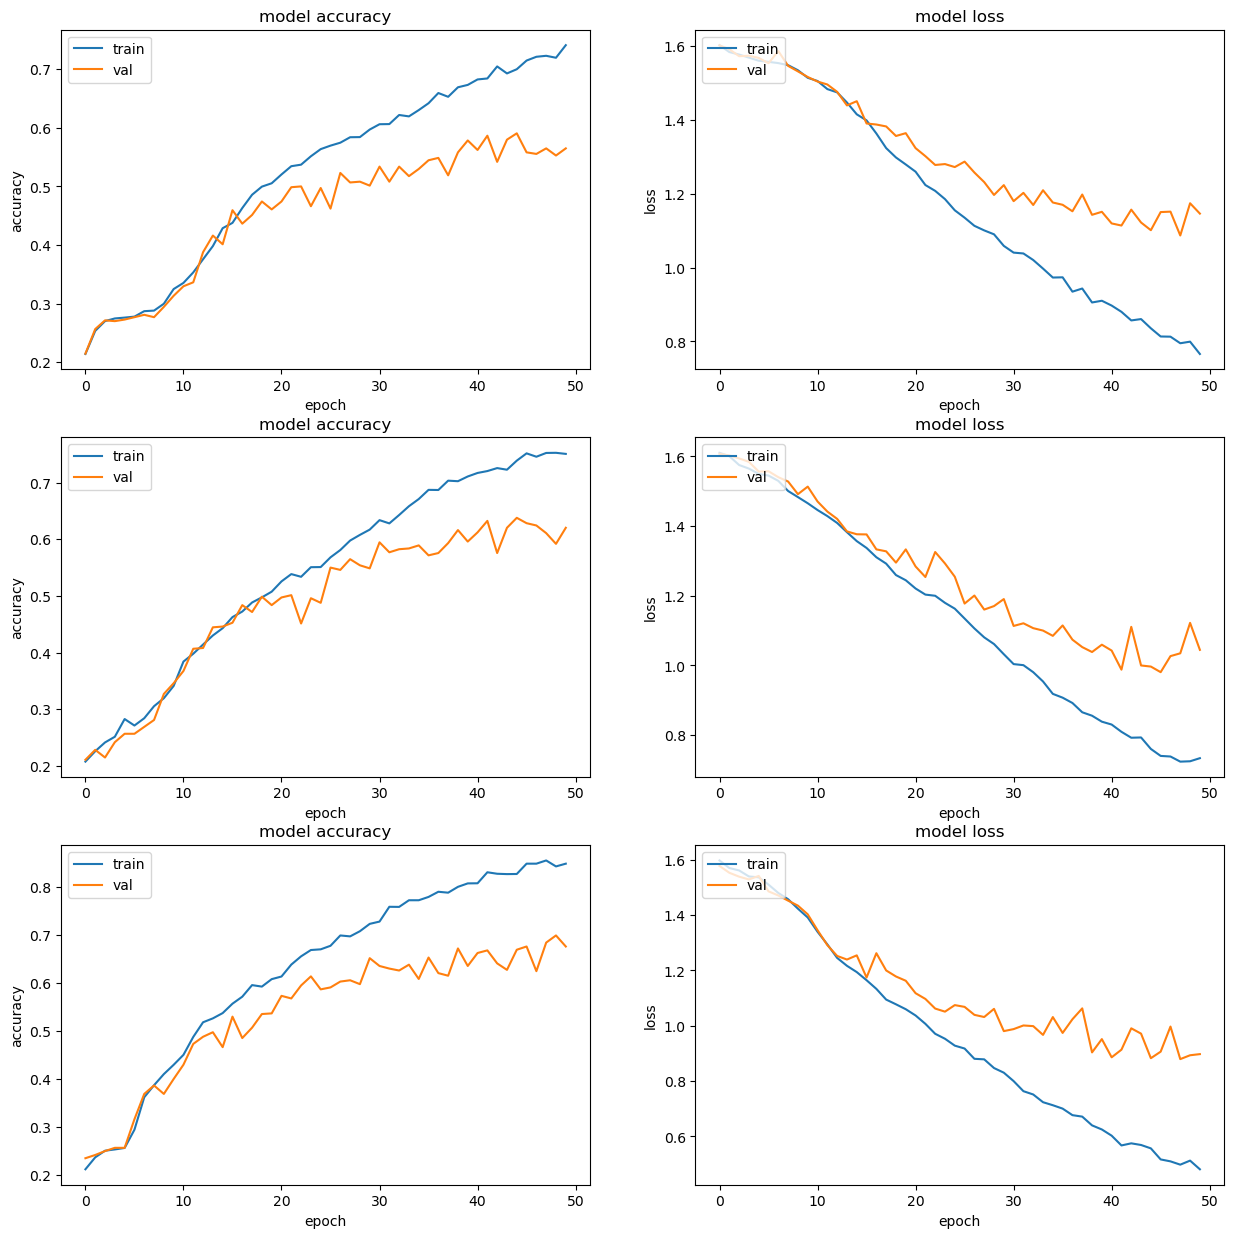

In [10]:
plot_stats(l0)

In [11]:
l1 = train_kfold(get_m, data1['x'], data1['y'], metadata)


Epoch 1/50
131/131 [==============================] - 3s 17ms/step - loss: 1.6089 - accuracy: 0.2054 - val_loss: 1.6087 - val_accuracy: 0.2189
Epoch 2/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6083 - accuracy: 0.2253 - val_loss: 1.6082 - val_accuracy: 0.2189
Epoch 3/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6082 - accuracy: 0.2255 - val_loss: 1.6081 - val_accuracy: 0.2189
Epoch 4/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6069 - accuracy: 0.2242 - val_loss: 1.6080 - val_accuracy: 0.2189
Epoch 5/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6080 - accuracy: 0.2241 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 6/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6071 - accuracy: 0.2210 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 7/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6078 - accuracy: 0.2176 - val_loss: 1.6079 - val_accuracy: 0.2189

Epoch 8/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6076 - accuracy: 0.2213 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 9/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6069 - accuracy: 0.2279 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 10/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6087 - accuracy: 0.2152 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 11/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6087 - accuracy: 0.2181 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 12/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6077 - accuracy: 0.2193 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 13/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6082 - accuracy: 0.2131 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 14/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6061 - accuracy: 0.2262 - val_loss: 1.6079 - val_accuracy: 0

Epoch 15/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6086 - accuracy: 0.2132 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 16/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6078 - accuracy: 0.2245 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 17/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6085 - accuracy: 0.2202 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 18/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6073 - accuracy: 0.2218 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 19/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6070 - accuracy: 0.2269 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 20/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6089 - accuracy: 0.2164 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 21/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6074 - accuracy: 0.2231 - val_loss: 1.6079 - val_accuracy:

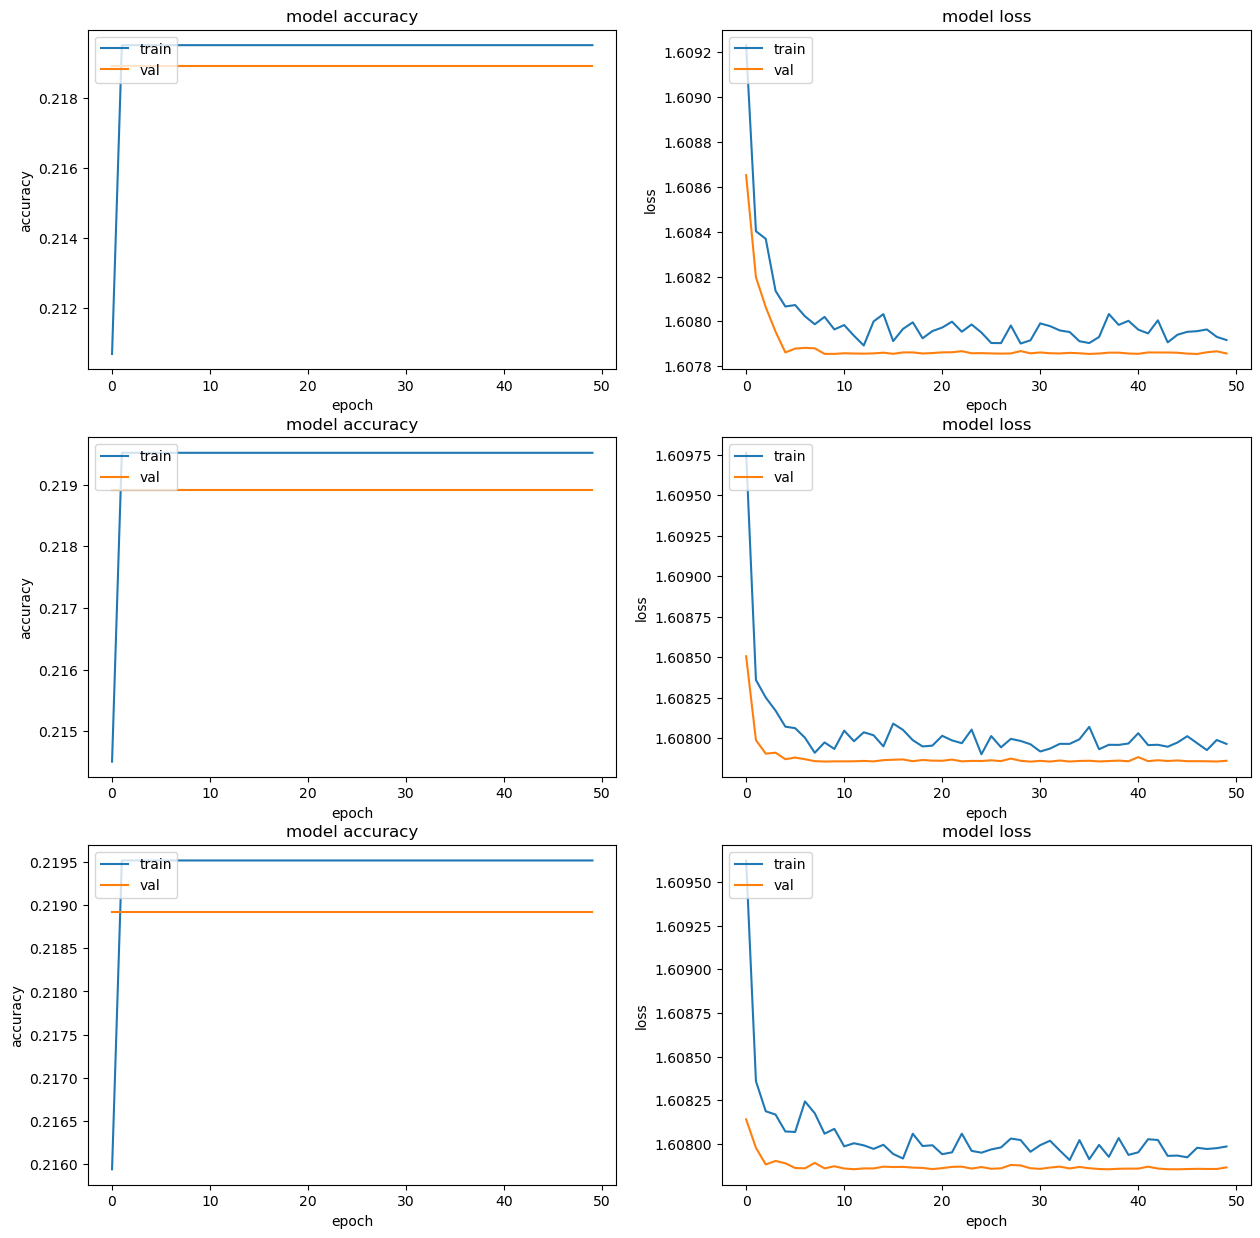

In [12]:
plot_stats(l1)

In [13]:
l2 = train_kfold(get_m, data2['x'], data2['y'], metadata)

Epoch 1/50
131/131 [==============================] - 3s 17ms/step - loss: 1.5954 - accuracy: 0.2154 - val_loss: 1.6222 - val_accuracy: 0.2041
Epoch 2/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6089 - accuracy: 0.2261 - val_loss: 1.6099 - val_accuracy: 0.2189
Epoch 3/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6086 - accuracy: 0.2172 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 4/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6093 - accuracy: 0.2091 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 5/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6084 - accuracy: 0.2164 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 6/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6099 - accuracy: 0.2059 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 7/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6075 - accuracy: 0.2184 - val_loss: 1.6079 - val_accuracy: 0.2189

Epoch 8/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6079 - accuracy: 0.2229 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 9/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6073 - accuracy: 0.2261 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 10/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6086 - accuracy: 0.2113 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 11/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6086 - accuracy: 0.2116 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 12/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6076 - accuracy: 0.2204 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 13/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6091 - accuracy: 0.2157 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 14/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6075 - accuracy: 0.2196 - val_loss: 1.6079 - val_accuracy: 0

Epoch 15/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6080 - accuracy: 0.2221 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 16/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6090 - accuracy: 0.2145 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 17/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6076 - accuracy: 0.2177 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 18/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6075 - accuracy: 0.2193 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 19/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6070 - accuracy: 0.2253 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 20/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6083 - accuracy: 0.2148 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 21/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6069 - accuracy: 0.2276 - val_loss: 1.6079 - val_accuracy:

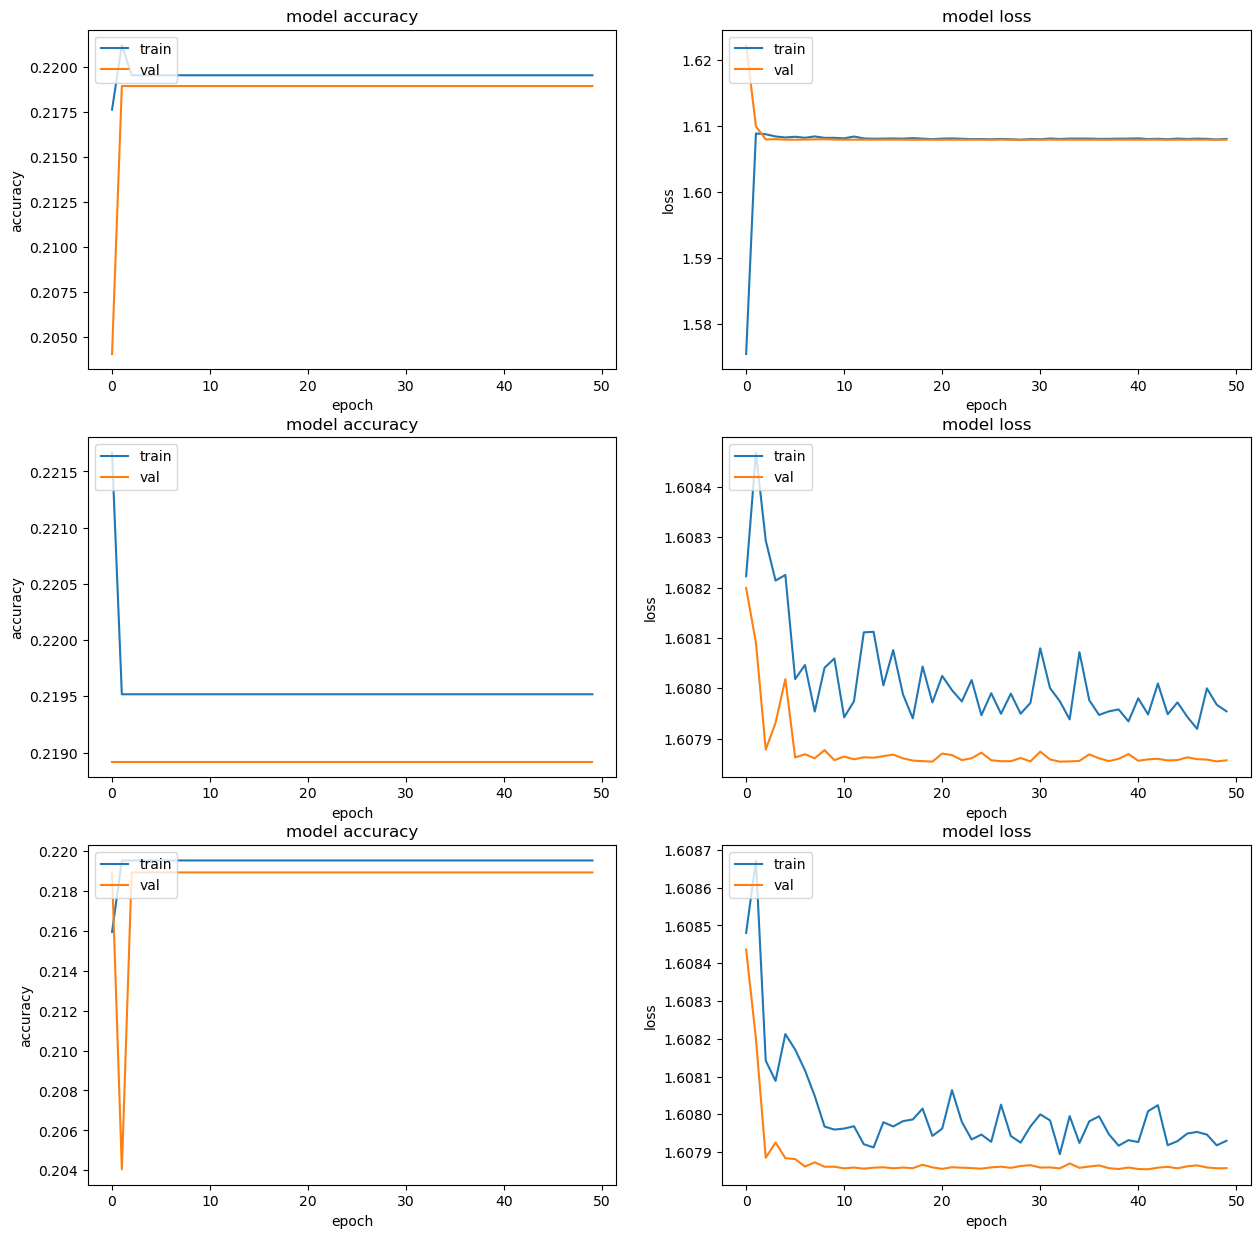

In [14]:
plot_stats(l2)

In [15]:
l3 = train_kfold(get_m, data3['x'], data3['y'], metadata)

Epoch 1/50
131/131 [==============================] - 3s 17ms/step - loss: 1.6115 - accuracy: 0.2208 - val_loss: 1.6071 - val_accuracy: 0.2068
Epoch 2/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5876 - accuracy: 0.2506 - val_loss: 1.5918 - val_accuracy: 0.2365
Epoch 3/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5330 - accuracy: 0.3031 - val_loss: 1.5485 - val_accuracy: 0.2743
Epoch 4/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5187 - accuracy: 0.3394 - val_loss: 1.4802 - val_accuracy: 0.3649
Epoch 5/50
131/131 [==============================] - 2s 15ms/step - loss: 1.4539 - accuracy: 0.3672 - val_loss: 1.4451 - val_accuracy: 0.3689
Epoch 6/50
131/131 [==============================] - 2s 15ms/step - loss: 1.4116 - accuracy: 0.3920 - val_loss: 1.3879 - val_accuracy: 0.4162
Epoch 7/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3845 - accuracy: 0.4046 - val_loss: 1.3537 - val_accuracy: 0.4135

Epoch 8/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6084 - accuracy: 0.2132 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 9/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6084 - accuracy: 0.2170 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 10/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6073 - accuracy: 0.2228 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 11/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6089 - accuracy: 0.2218 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 12/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6077 - accuracy: 0.2199 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 13/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6083 - accuracy: 0.2204 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 14/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6066 - accuracy: 0.2209 - val_loss: 1.6079 - val_accuracy: 0

Epoch 15/50
131/131 [==============================] - 2s 15ms/step - loss: 1.0840 - accuracy: 0.6028 - val_loss: 1.1764 - val_accuracy: 0.5257
Epoch 16/50
131/131 [==============================] - 2s 15ms/step - loss: 1.0477 - accuracy: 0.6160 - val_loss: 1.1928 - val_accuracy: 0.5027
Epoch 17/50
131/131 [==============================] - 2s 15ms/step - loss: 1.0167 - accuracy: 0.6284 - val_loss: 1.1793 - val_accuracy: 0.5284
Epoch 18/50
131/131 [==============================] - 2s 15ms/step - loss: 0.9942 - accuracy: 0.6313 - val_loss: 1.1648 - val_accuracy: 0.5216
Epoch 19/50
131/131 [==============================] - 2s 15ms/step - loss: 0.9605 - accuracy: 0.6496 - val_loss: 1.1686 - val_accuracy: 0.5189
Epoch 20/50
131/131 [==============================] - 2s 15ms/step - loss: 0.9351 - accuracy: 0.6473 - val_loss: 1.1391 - val_accuracy: 0.5338
Epoch 21/50
131/131 [==============================] - 2s 15ms/step - loss: 0.9085 - accuracy: 0.6683 - val_loss: 1.2054 - val_accuracy:

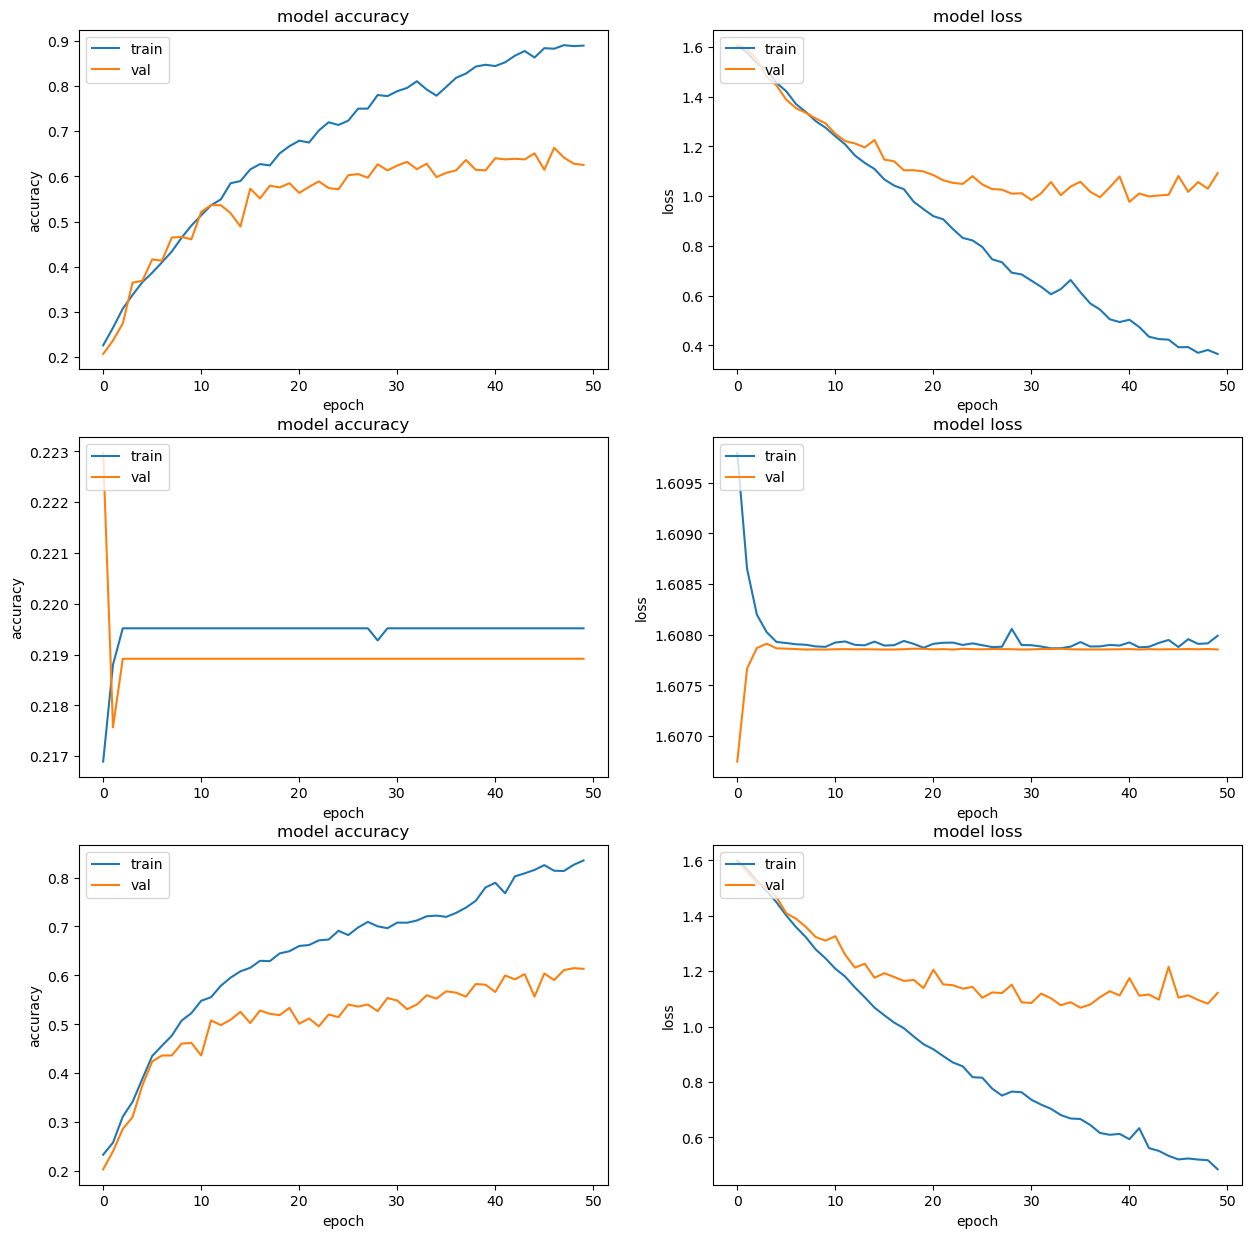

In [16]:
plot_stats(l3)

# With standardization

Standardize samples' matrix<br>The matrix are flatted to an array of features and the resulting dataset is transformed to have mean 0 and std 1

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [20]:
data0['x'].flatten().shape

(164734848,)

In [21]:
data0['xs'] = scaler.fit_transform(data0['x'].reshape(4931,-1)).reshape((4931, 261, 128, 1))
data1['xs'] = scaler.fit_transform(data1['x'].reshape(4931,-1)).reshape((4931, 261, 128, 1))
data2['xs'] = scaler.fit_transform(data2['x'].reshape(4931,-1)).reshape((4931, 261, 128, 1))
data3['xs'] = scaler.fit_transform(data3['x'].reshape(4931,-1)).reshape((4931, 261, 128, 1))

In [22]:
data0['xs'].std(), data0['xs'].mean()

(0.99999934, -1.9302314e-07)

In [23]:
l00 = train_kfold(get_m, data0['xs'], data0['y'], metadata)

Epoch 1/50
131/131 [==============================] - 3s 17ms/step - loss: 1.5869 - accuracy: 0.2497 - val_loss: 1.5399 - val_accuracy: 0.2784
Epoch 2/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5149 - accuracy: 0.3063 - val_loss: 1.4648 - val_accuracy: 0.3311
Epoch 3/50
131/131 [==============================] - 2s 14ms/step - loss: 1.4454 - accuracy: 0.3667 - val_loss: 1.4140 - val_accuracy: 0.3514
Epoch 4/50
131/131 [==============================] - 2s 14ms/step - loss: 1.4075 - accuracy: 0.3811 - val_loss: 1.4176 - val_accuracy: 0.3770
Epoch 5/50
131/131 [==============================] - 2s 14ms/step - loss: 1.3693 - accuracy: 0.4237 - val_loss: 1.3240 - val_accuracy: 0.4608
Epoch 6/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3447 - accuracy: 0.4334 - val_loss: 1.3307 - val_accuracy: 0.4297
Epoch 7/50
131/131 [==============================] - 2s 14ms/step - loss: 1.3063 - accuracy: 0.4573 - val_loss: 1.2884 - val_accuracy: 0.4730

Epoch 8/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3557 - accuracy: 0.4170 - val_loss: 1.3231 - val_accuracy: 0.4081
Epoch 9/50
131/131 [==============================] - 2s 14ms/step - loss: 1.3035 - accuracy: 0.4467 - val_loss: 1.3023 - val_accuracy: 0.4581
Epoch 10/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2944 - accuracy: 0.4511 - val_loss: 1.2849 - val_accuracy: 0.4446
Epoch 11/50
131/131 [==============================] - 2s 14ms/step - loss: 1.2705 - accuracy: 0.4516 - val_loss: 1.2714 - val_accuracy: 0.4784
Epoch 12/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2407 - accuracy: 0.4733 - val_loss: 1.2616 - val_accuracy: 0.4622
Epoch 13/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2370 - accuracy: 0.4717 - val_loss: 1.2507 - val_accuracy: 0.4757
Epoch 14/50
131/131 [==============================] - 2s 15ms/step - loss: 1.1943 - accuracy: 0.4930 - val_loss: 1.2398 - val_accuracy: 0

Epoch 15/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3656 - accuracy: 0.4605 - val_loss: 1.3649 - val_accuracy: 0.4351
Epoch 16/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3310 - accuracy: 0.4594 - val_loss: 1.3581 - val_accuracy: 0.4716
Epoch 17/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2974 - accuracy: 0.4978 - val_loss: 1.3248 - val_accuracy: 0.4838
Epoch 18/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2847 - accuracy: 0.5082 - val_loss: 1.3070 - val_accuracy: 0.4811
Epoch 19/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2489 - accuracy: 0.5389 - val_loss: 1.2808 - val_accuracy: 0.5176
Epoch 20/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2287 - accuracy: 0.5513 - val_loss: 1.2523 - val_accuracy: 0.5230
Epoch 21/50
131/131 [==============================] - 2s 15ms/step - loss: 1.2132 - accuracy: 0.5657 - val_loss: 1.2852 - val_accuracy:

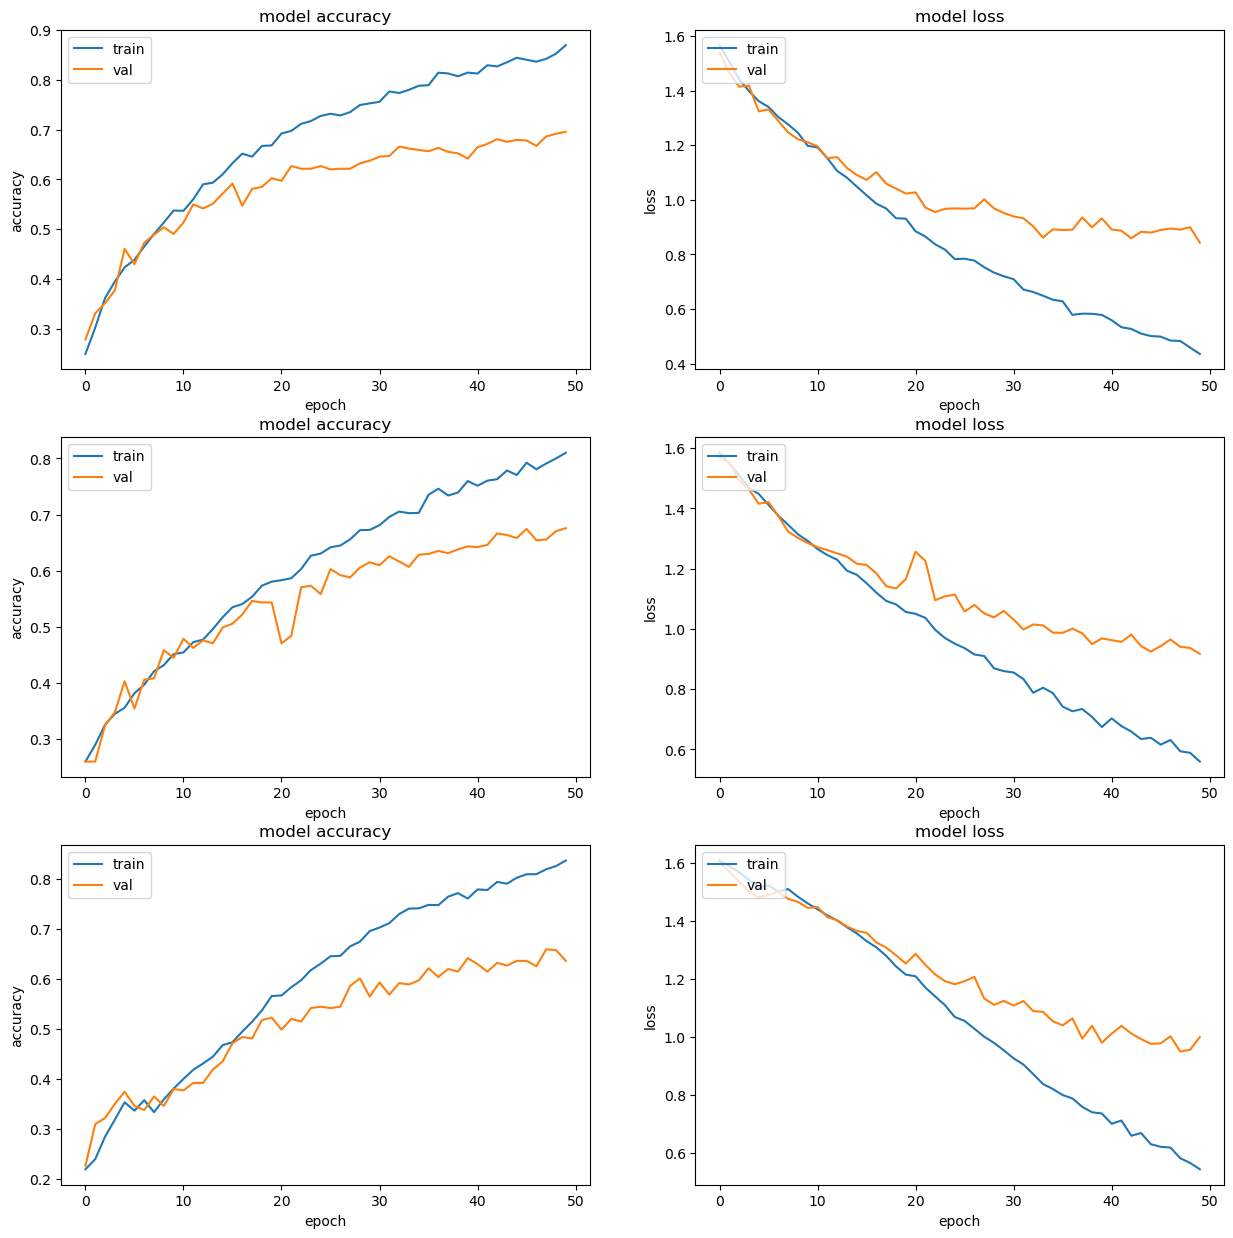

In [24]:
plot_stats(l00)

In [25]:
l11 = train_kfold(get_m, data1['xs'], data1['y'], metadata)


Epoch 1/50
131/131 [==============================] - 3s 17ms/step - loss: 1.5864 - accuracy: 0.2673 - val_loss: 1.6122 - val_accuracy: 0.2189
Epoch 2/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6093 - accuracy: 0.2152 - val_loss: 1.6104 - val_accuracy: 0.2189
Epoch 3/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6082 - accuracy: 0.2227 - val_loss: 1.6080 - val_accuracy: 0.2189
Epoch 4/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6077 - accuracy: 0.2209 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 5/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6094 - accuracy: 0.2096 - val_loss: 1.6085 - val_accuracy: 0.2189
Epoch 6/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6106 - accuracy: 0.2152 - val_loss: 1.6119 - val_accuracy: 0.2189
Epoch 7/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6074 - accuracy: 0.2201 - val_loss: 1.6079 - val_accuracy: 0.2189

Epoch 8/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6082 - accuracy: 0.2178 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 9/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6072 - accuracy: 0.2218 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 10/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6071 - accuracy: 0.2302 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 11/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6083 - accuracy: 0.2145 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 12/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6070 - accuracy: 0.2170 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 13/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6083 - accuracy: 0.2132 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 14/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6084 - accuracy: 0.2176 - val_loss: 1.6079 - val_accuracy: 0

Epoch 15/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6078 - accuracy: 0.2216 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 16/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6084 - accuracy: 0.2169 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 17/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6082 - accuracy: 0.2195 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 18/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6075 - accuracy: 0.2156 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 19/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6099 - accuracy: 0.2097 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 20/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6096 - accuracy: 0.2158 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 21/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6070 - accuracy: 0.2254 - val_loss: 1.6079 - val_accuracy:

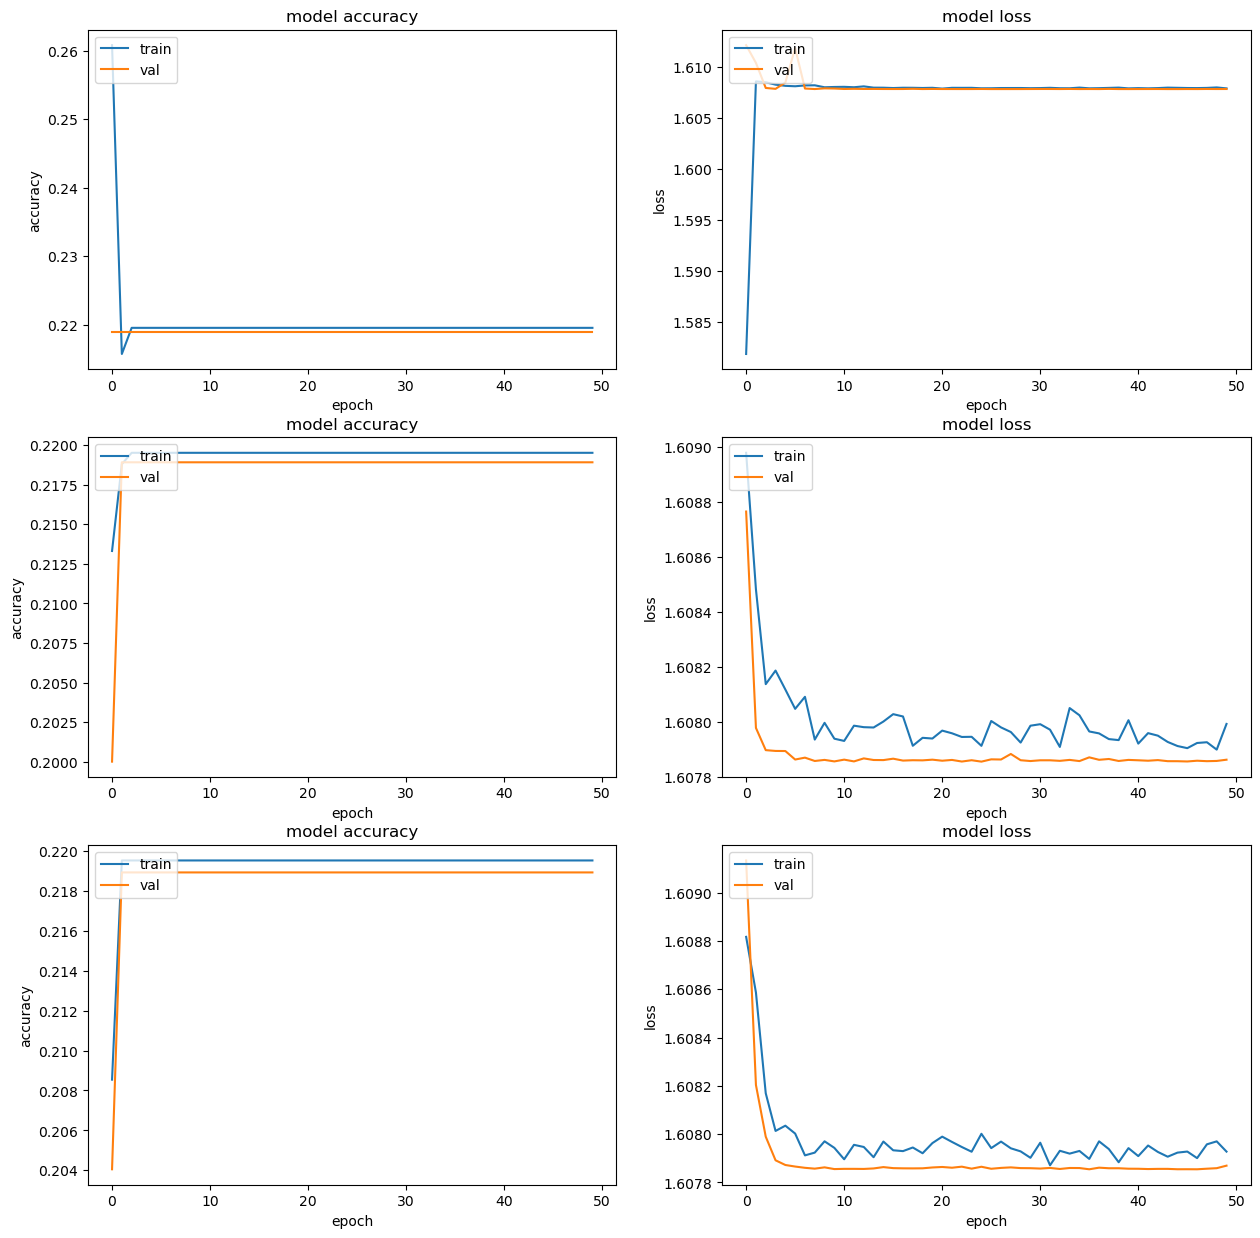

In [26]:
plot_stats(l11)

In [27]:
l22 = train_kfold(get_m, data2['xs'], data2['y'], metadata)

Epoch 1/50
131/131 [==============================] - 3s 17ms/step - loss: 1.6002 - accuracy: 0.2368 - val_loss: 1.6149 - val_accuracy: 0.2041
Epoch 2/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6092 - accuracy: 0.2031 - val_loss: 1.6098 - val_accuracy: 0.2041
Epoch 3/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6089 - accuracy: 0.2188 - val_loss: 1.6081 - val_accuracy: 0.2189
Epoch 4/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6081 - accuracy: 0.2141 - val_loss: 1.6085 - val_accuracy: 0.2189
Epoch 5/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6075 - accuracy: 0.2236 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 6/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6083 - accuracy: 0.2155 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 7/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6084 - accuracy: 0.2200 - val_loss: 1.6079 - val_accuracy: 0.2189

Epoch 8/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6065 - accuracy: 0.2152 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 9/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6081 - accuracy: 0.2186 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 10/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6068 - accuracy: 0.2270 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 11/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6086 - accuracy: 0.2143 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 12/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6080 - accuracy: 0.2174 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 13/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6082 - accuracy: 0.2218 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 14/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6077 - accuracy: 0.2166 - val_loss: 1.6079 - val_accuracy: 0

Epoch 15/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6077 - accuracy: 0.2189 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 16/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6083 - accuracy: 0.2190 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 17/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6089 - accuracy: 0.2095 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 18/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6073 - accuracy: 0.2201 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 19/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6099 - accuracy: 0.1991 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 20/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6068 - accuracy: 0.2198 - val_loss: 1.6079 - val_accuracy: 0.2189
Epoch 21/50
131/131 [==============================] - 2s 14ms/step - loss: 1.6063 - accuracy: 0.2265 - val_loss: 1.6079 - val_accuracy:

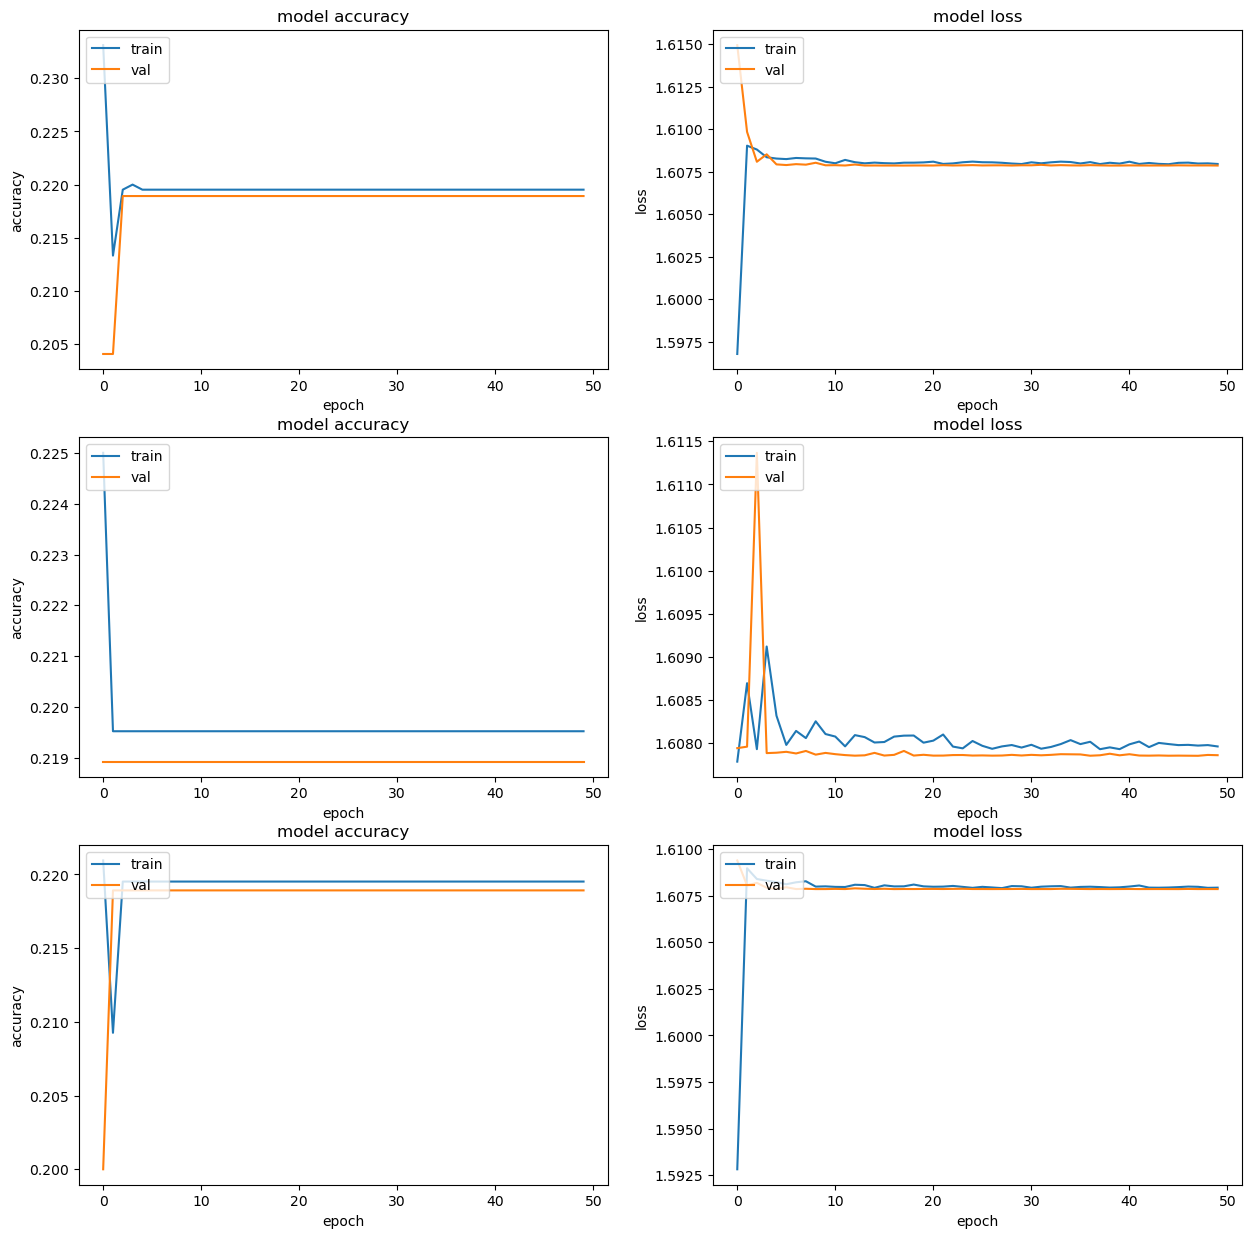

In [28]:
plot_stats(l22)

In [29]:
l33 = train_kfold(get_m, data3['xs'], data3['y'], metadata)

Epoch 1/50
131/131 [==============================] - 3s 18ms/step - loss: 1.6087 - accuracy: 0.2240 - val_loss: 1.6032 - val_accuracy: 0.2243
Epoch 2/50
131/131 [==============================] - 2s 15ms/step - loss: 1.6033 - accuracy: 0.2347 - val_loss: 1.5982 - val_accuracy: 0.2419
Epoch 3/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5928 - accuracy: 0.2295 - val_loss: 1.5912 - val_accuracy: 0.2378
Epoch 4/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5833 - accuracy: 0.2345 - val_loss: 1.5739 - val_accuracy: 0.2392
Epoch 5/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5698 - accuracy: 0.2307 - val_loss: 1.5688 - val_accuracy: 0.2365
Epoch 6/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5597 - accuracy: 0.2680 - val_loss: 1.5595 - val_accuracy: 0.2905
Epoch 7/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5600 - accuracy: 0.2840 - val_loss: 1.5756 - val_accuracy: 0.2365

Epoch 8/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5157 - accuracy: 0.3443 - val_loss: 1.5321 - val_accuracy: 0.3243
Epoch 9/50
131/131 [==============================] - 2s 15ms/step - loss: 1.4911 - accuracy: 0.3651 - val_loss: 1.5176 - val_accuracy: 0.3257
Epoch 10/50
131/131 [==============================] - 2s 15ms/step - loss: 1.4727 - accuracy: 0.3799 - val_loss: 1.5244 - val_accuracy: 0.3230
Epoch 11/50
131/131 [==============================] - 2s 15ms/step - loss: 1.4587 - accuracy: 0.3844 - val_loss: 1.4591 - val_accuracy: 0.3838
Epoch 12/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3973 - accuracy: 0.4308 - val_loss: 1.4304 - val_accuracy: 0.3946
Epoch 13/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3691 - accuracy: 0.4509 - val_loss: 1.4189 - val_accuracy: 0.3770
Epoch 14/50
131/131 [==============================] - 2s 15ms/step - loss: 1.3326 - accuracy: 0.4590 - val_loss: 1.3965 - val_accuracy: 0

Epoch 15/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5618 - accuracy: 0.2624 - val_loss: 1.5544 - val_accuracy: 0.2892
Epoch 16/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5623 - accuracy: 0.2790 - val_loss: 1.5656 - val_accuracy: 0.2581
Epoch 17/50
131/131 [==============================] - 2s 14ms/step - loss: 1.5641 - accuracy: 0.2664 - val_loss: 1.5692 - val_accuracy: 0.2581
Epoch 18/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5504 - accuracy: 0.2695 - val_loss: 1.5687 - val_accuracy: 0.2568
Epoch 19/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5566 - accuracy: 0.2741 - val_loss: 1.5770 - val_accuracy: 0.2473
Epoch 20/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5550 - accuracy: 0.2646 - val_loss: 1.5573 - val_accuracy: 0.2689
Epoch 21/50
131/131 [==============================] - 2s 15ms/step - loss: 1.5467 - accuracy: 0.2822 - val_loss: 1.5472 - val_accuracy:

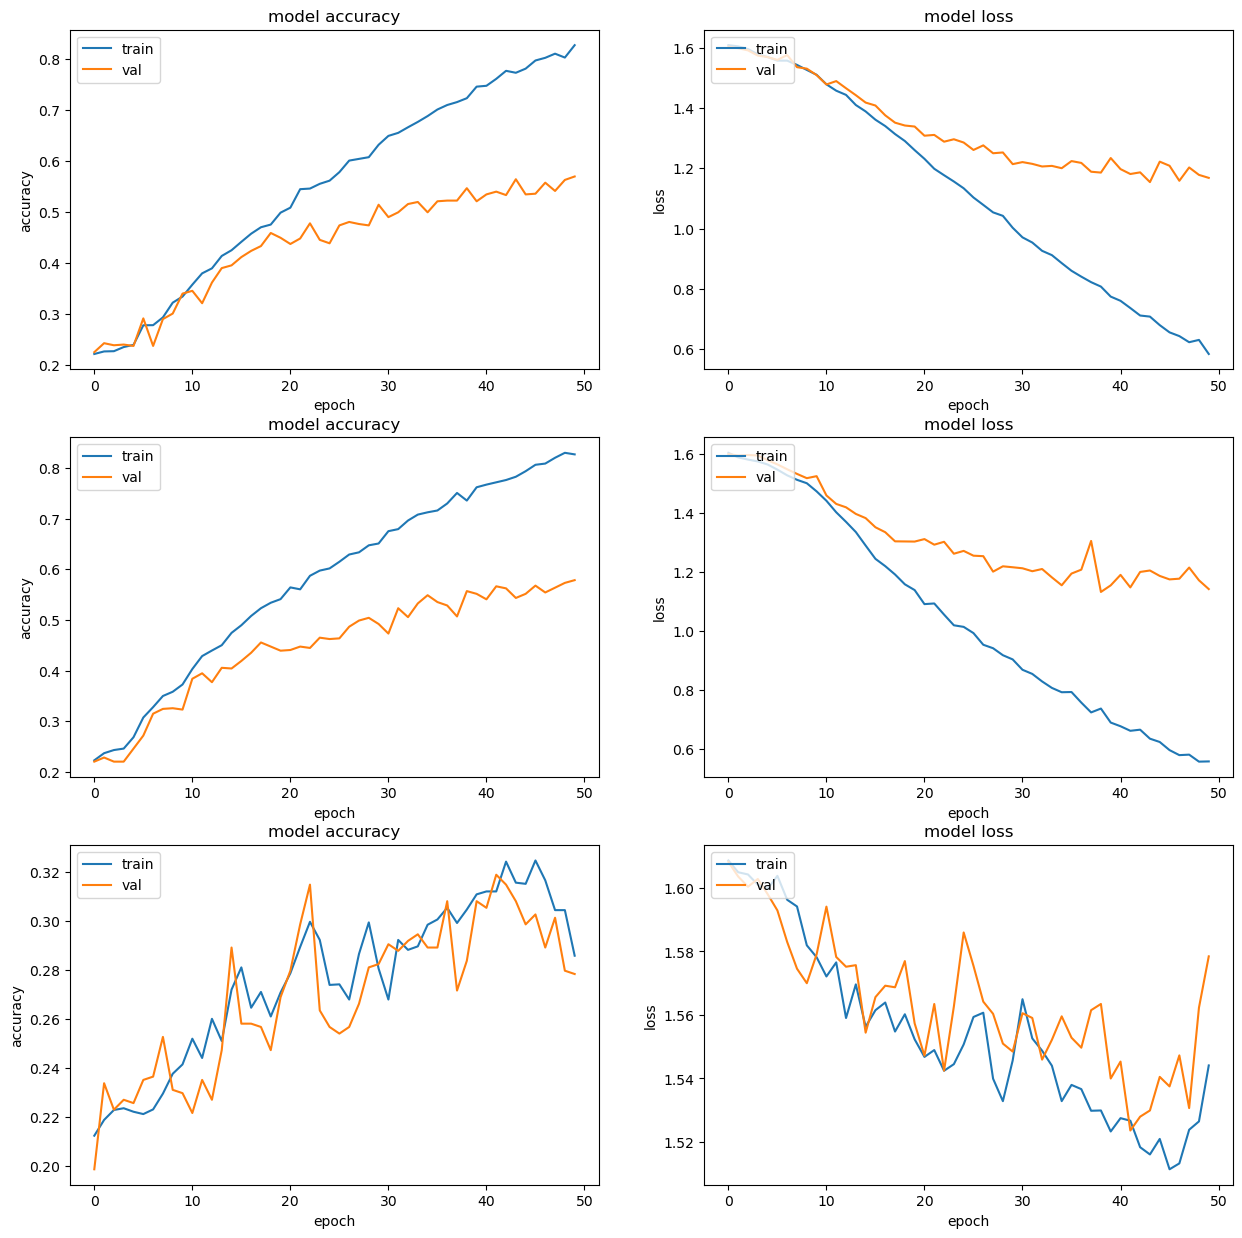

In [30]:
plot_stats(l33)